In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
import quandl

quandl.ApiConfig.api_key = 'HH4sx9wtre3hJ6_py3Pq'

class Bollinger(object):

    def __init__(self, ticker, start=datetime.now() - BDay(60), end=datetime.now().date()):
        '''Creates a Bollinger object of the given stock to work with. Defaults to a 60 day window with a 30 day Exponentially Weighted Moving Average.'''
        self.ticker = ticker
        self.start = start # Datetime objects are in the format yyyy-mm-dd
        self.end = end
        self.data = self._acquire_data()

    def _acquire_data(self):
        '''Retrieves End-of-Day closing price data using the Quandl API.'''
        stock_prices = quandl.get_table('WIKI/PRICES', qopts={'columns':['date', 'adj_close']}, ticker=self.ticker, date={'gte':self.start, 'lte':self.end})
        stock_prices.index = pd.to_datetime(stock_prices['date'])
        stock_prices.drop('date', axis=1, inplace=True)

        # Adjusted Close Simple Moving Average
        stock_prices['30-day_sma'] = stock_prices['adj_close'].rolling(30).mean()

        # Adjusted Close Exponentially Weighted Moving Average
        stock_prices['30-day_ewma'] = stock_prices['adj_close'].ewm(span=30).mean()

        # Upper Band = EWMA + 2*Standard Deviation over same period
        stock_prices['upper_bound'] = stock_prices['30-day_ewma'] + 2*stock_prices['adj_close'].rolling(30).std()

        # Lower Band = EWMA - 2*Standard Deviation over same period
        stock_prices['lower_bound'] = stock_prices['30-day_ewma'] - 2*stock_prices['adj_close'].rolling(30).std()

        return stock_prices

    def _get_last_date(self, date=datetime.now().date()):
        '''Returns the last date for which data is available before the given date (defaults to today).'''
        date = pd.to_datetime(date).date()
        iterations = 0
        while date not in self.data.index:
            date = date - timedelta(days=1)
            if iterations > 365:
                raise IndexError('Date out of bounds')
            iterations += 1
        return date
    
    def last_close_price(self):
        return self.data.loc[self._get_last_date(), 'adj_close']
    
    def date_of_max_value(self):
        return self.data['adj_close'].idxmax().date()
    
    def max_value(self):
        return self.data['adj_close'].max()
    
    def get_price(self, date=datetime.now().date()):
        if date not in self.data.index:
            date = self._get_last_date(date)
        return self.data.loc[date, 'adj_close']

    def is_too_high(self, date=datetime.now().date()):
        '''Checks to see if the close price for a given date is greater than the upper Bollinger band.'''
        date = self._get_last_date(date)
        if (self.data.loc[date, 'adj_close'] > self.data.loc[date, 'upper_bound']):
            return True
        else:
            return False

    def is_too_low(self, date=datetime.now().date()):
        '''Checks to see if the close price for a given date is less than the lower Bollinger band.'''
        date = self._get_last_date(date)
        if (self.data.loc[date, 'adj_close'] < self.data.loc[date, 'lower_bound']):
            return True
        else:
            return False

    def is_stable(self, date=datetime.now().date()):
        '''Checks if the closing price for a given day is within the Bollinger bands.'''
        if type(date) != datetime:
            date = pd.to_datetime(date)
        if self.is_too_high(date):
            print('On {}, {} was trading above its upper Bollinger volatility margin at a price of {}. This is much higher than normal - consider closing your position or be cautious when investing at this time.'.format(date.strftime('%B %d, %Y'), self.ticker, self.get_price(date)))
        elif self.is_too_low(date):
            print('On {}, {} was trading below its lower Bollinger volatility margin at a price of {}. Consider whether the market is overreacting to an event - this stock may be currently undervalued.'.format(date.strftime('%B %d, %Y'), self.ticker, self.get_price(date)))
        else:
            print('On {}, {} was trading stably within its Bollinger volatility margins at a price of {}.'.format(date.strftime('%B %d, %Y'), self.ticker, self.get_price(date)))
                 
    def visualize(self):
        '''Plots key information alongside each other.'''
        self.data[['adj_close', 'upper_bound', 'lower_bound']].plot(figsize=(18,6))
        plt.show()

On October 29, 2017, TSLA was trading stably within its Bollinger volatility margins at a price of 320.87.
On September 18, 2017, TSLA was trading above its upper Bollinger volatility margin at a price of 385.0. This is much higher than normal - consider closing your position or be cautious when investing at this time.


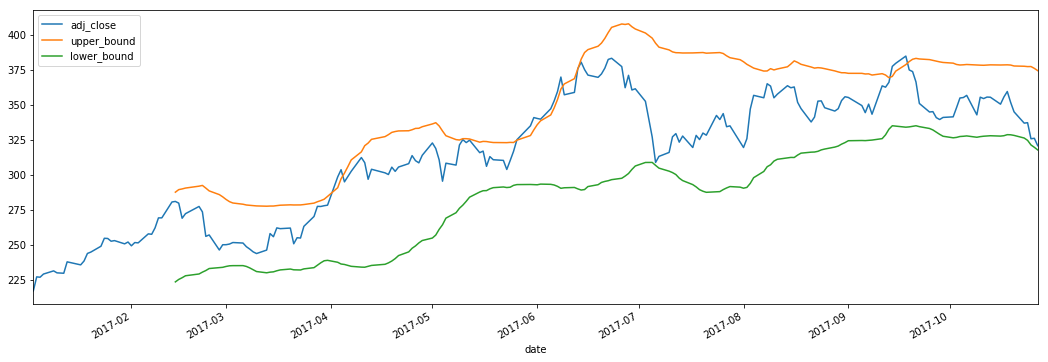

In [62]:
tesla = Bollinger('TSLA', '2017-01-01')
tesla.is_stable()
tesla.is_stable('2017-09-18')
tesla.visualize()